# Substance Detecting using ML

## Importig Libraries

In [9]:
import os
import zipfile
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_pre
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mob_pre

## Importing ZIP file to Colab

In [5]:
from google.colab import files
uploaded = files.upload()

Saving DATA SET.zip to DATA SET.zip


## Unzipping the Zip file

In [15]:
with zipfile.ZipFile('DATA SET.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

data_dir = './DATA SET'
img_size = (224, 224)
batch_size = 32

## Using CNN Model

In [10]:
USE_MOBILENET = False

if USE_MOBILENET:
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    preprocess = mob_pre
else:
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    preprocess = vgg_pre

## Loading and preprocessing images

In [16]:
datagen = ImageDataGenerator(preprocessing_function=preprocess)

generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 125 images belonging to 2 classes.


## Features Extraction

In [17]:
print("Extracting CNN features...")
features = base_model.predict(generator, verbose=1)
X = features.reshape((features.shape[0], -1))
y = generator.classes

🔍 Extracting CNN features...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 67s 17s/step


## Train and split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

## Train XGBoost classifier

In [26]:
print("Training XGBoost model...")
model = XGBClassifier()
model.fit(X_train, y_train)

Training XGBoost model...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Predict and Evaluate

In [32]:
y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred)*100 )
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Non-Smoker', 'Smoker']))


Accuracy: 72.0

Classification Report:
               precision    recall  f1-score   support

  Non-Smoker       0.90      0.60      0.72        15
      Smoker       0.60      0.90      0.72        10

    accuracy                           0.72        25
   macro avg       0.75      0.75      0.72        25
weighted avg       0.78      0.72      0.72        25



## Correlation Without PCA

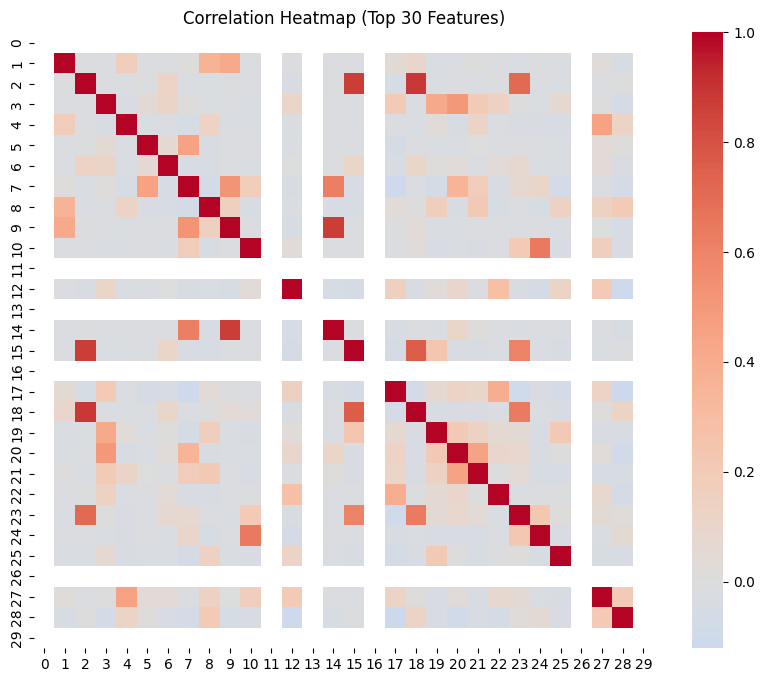

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to DataFrame
X_df = pd.DataFrame(X)

# Select only first 30 or top 30 important features
X_subset = X_df.iloc[:, :30]  # or use feature importance to select top 30

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(X_subset.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (Top 30 Features)")
plt.show()


## Visulization the Results

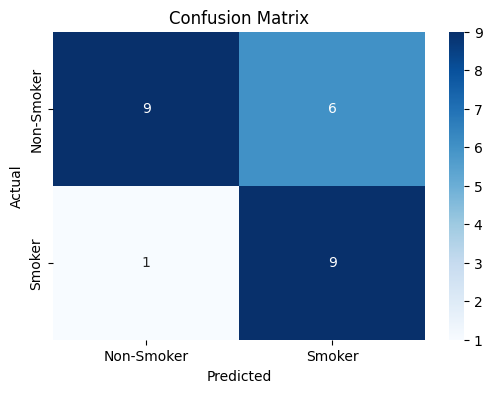

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Checking for Imbalances

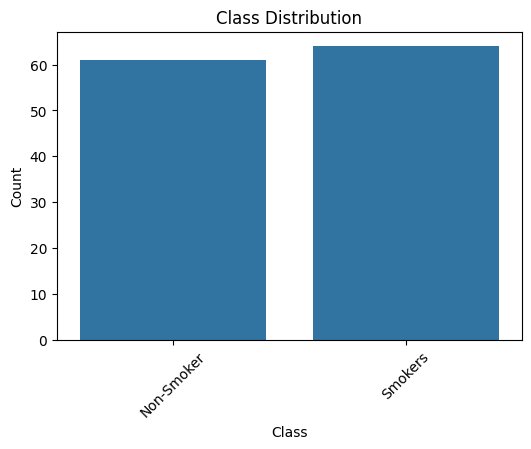

In [22]:
labels = generator.class_indices
label_map = dict((v,k) for k,v in labels.items())

label_names = [label_map[i] for i in generator.classes]

plt.figure(figsize=(6,4))
sns.countplot(x=label_names)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


## Feature Reduction Using PCA

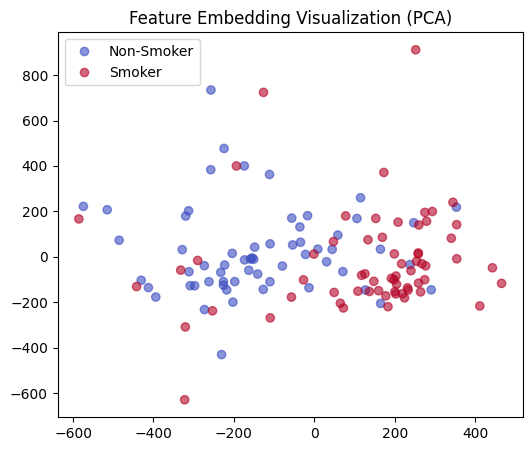

In [23]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Choose one: PCA (faster) or t-SNE (better for clusters)
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

# X_vis = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['Non-Smoker', 'Smoker'])
plt.title("Feature Embedding Visualization (PCA)")
plt.show()


## ROC Curve

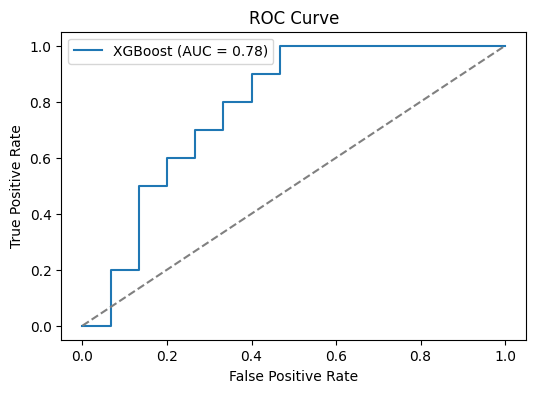

In [24]:
from sklearn.metrics import roc_curve, auc

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='XGBoost (AUC = %.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
